In [112]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as met
from collections import Counter
import itertools

%matplotlib inline
pd.options.display.max_seq_items = 1000
pd.options.display.max_colwidth = 200

In [82]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
ids = test.pop("test_id")
train.head() 

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


<h1> exploratory analysis</h1>

In [83]:
train.isnull().any()

id              False
qid1            False
qid2            False
question1       False
question2        True
is_duplicate    False
dtype: bool

In [84]:
train.loc[train["question2"].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [85]:
train = train.dropna()

In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404288 entries, 0 to 404289
Data columns (total 6 columns):
id              404288 non-null int64
qid1            404288 non-null int64
qid2            404288 non-null int64
question1       404288 non-null object
question2       404288 non-null object
is_duplicate    404288 non-null int64
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [87]:
train.describe()

,id,qid1,qid2,is_duplicate
count,404288.000000,404288.000000,404288.000000,404288.000000
mean,202144.739107,217243.834014,220955.885824,0.369200
std,116708.804775,157752.016842,159903.544568,0.482589
min,0.000000,1.000000,2.000000,0.000000
25%,101071.750000,74436.750000,74726.750000,0.000000
50%,202145.500000,192182.000000,197053.000000,0.000000
75%,303217.250000,346574.000000,354693.000000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [88]:
foo = train.groupby(['qid1']).size().reset_index().rename(columns={0:'count'})
foo.ix[foo["count"] > 1].head()

,qid1,count
1,3,4
5,9,3
15,27,2
16,29,5
17,31,7


In [89]:
train.ix[(train["qid1"] == 31) | (train["qid2"] == 31)]

,id,qid1,qid2,question1,question2,is_duplicate
15,15,31,32,What would a Trump presidency mean for current international master’s students on an F1 visa?,How will a Trump presidency affect the students presently in US or planning to study in US?,1
160090,160090,31,6937,What would a Trump presidency mean for current international master’s students on an F1 visa?,How will Trump’s presidency affect international students in the US?,1
215442,215442,31,88834,What would a Trump presidency mean for current international master’s students on an F1 visa?,How would a Trump presidency affect schools accessibility for international students?,1
218075,218075,31,1101,What would a Trump presidency mean for current international master’s students on an F1 visa?,How would Trump presidency affect Indian students in the US?,1
238721,238721,31,11435,What would a Trump presidency mean for current international master’s students on an F1 visa?,What will happen to international students in the US if Donald Trump becomes president?,1
238955,238955,31,93145,What would a Trump presidency mean for current international master’s students on an F1 visa?,Will the Trump factor affect the admission of international students in the USA?,1
290679,290679,249733,31,Will international college students be negatively affected if Trump becomes president?,What would a Trump presidency mean for current international master’s students on an F1 visa?,1
344612,344612,44686,31,What does a Trump presidency mean for Indian students looking to pursue Master's degrees in USA?,What would a Trump presidency mean for current international master’s students on an F1 visa?,1
364513,364513,31,12544,What would a Trump presidency mean for current international master’s students on an F1 visa?,How will Trump's presidency affect prospective international students from Syria?,1


In [90]:
foo = train.groupby("is_duplicate", as_index=False)['id'].count()
foo = foo.rename(columns = {list(foo)[1]: 'count'})
print(foo)

   is_duplicate   count
0             0  255025
1             1  149263


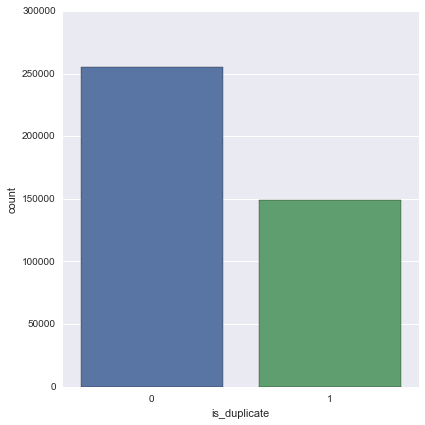

In [91]:
g = sns.factorplot(x="is_duplicate", y="count",  data=foo, kind="bar", size=6)

(-0.5, 1439.5, 1079.5, -0.5)

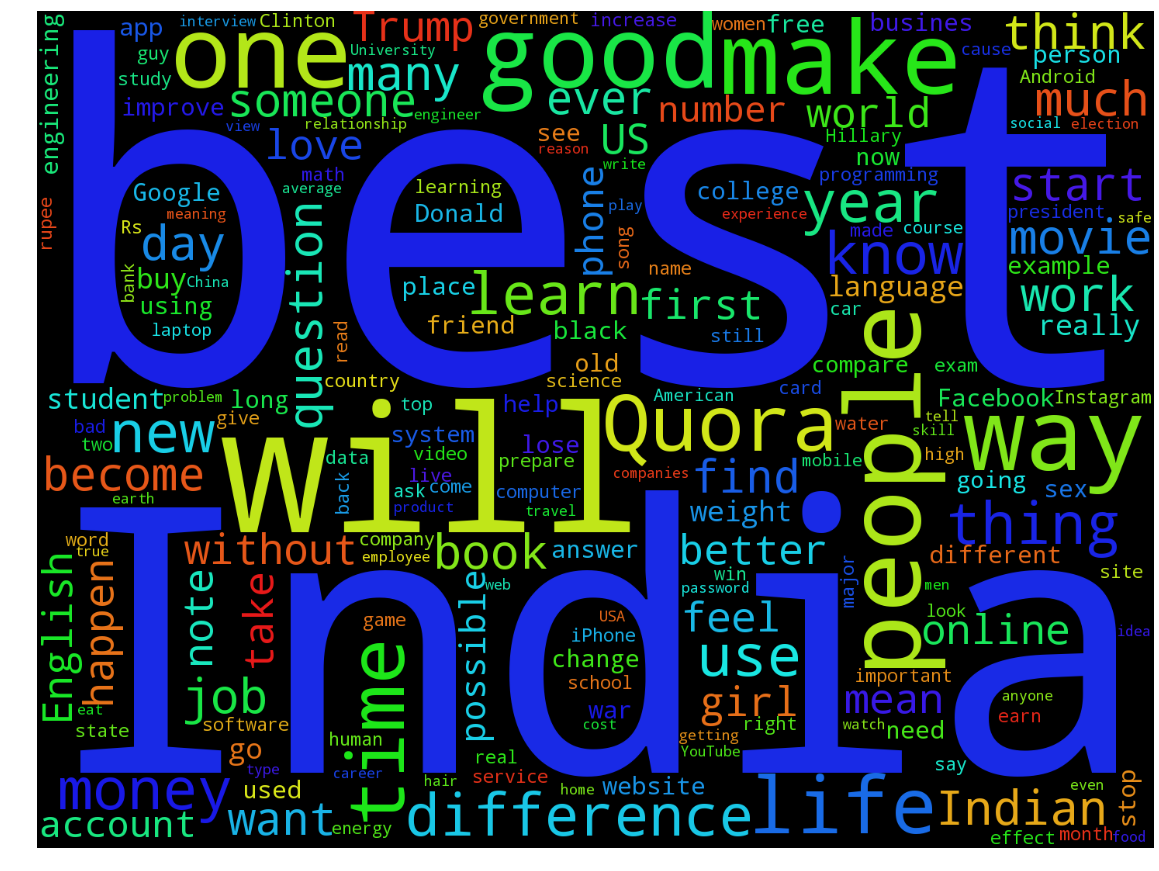

In [92]:
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

<h1>Feature Engineering</h1>

<h2>Cleaning up questions and finding ratio of words in common</h2>

In [93]:
def normalized_word_share(row):
    w1 = set(map(lambda word: word, row['question1_cleaned'].split(" ")))
    w2 = set(map(lambda word: word, row['question2_cleaned'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1 | w2))

def clean_question(q, translator):
    q = q.lower().strip().translate(translator)
    return q

translator = str.maketrans('', '', string.punctuation)
train['question1_cleaned'] = train['question1'].apply(clean_question, args=(translator,))
train['question2_cleaned'] = train['question2'].apply(clean_question, args=(translator,))

train['word_share'] = train.apply(normalized_word_share, axis=1)

train.head()


,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,word_share
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,what is the step by step guide to invest in share market in india,what is the step by step guide to invest in share market,0.916667
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,what is the story of kohinoor kohinoor diamond,what would happen if the indian government stole the kohinoor kohinoor diamond back,0.285714
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,how can i increase the speed of my internet connection while using a vpn,how can internet speed be increased by hacking through dns,0.200000
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divided by 2423,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,which one dissolve in water quikly sugar salt methane and carbon di oxide,which fish would survive in salt water,0.250000


In [94]:
train.loc[(train['word_share']==1) & (train['is_duplicate'] == 0), ["id", "question1", "question2"]]

,id,question1,question2
585,585,Can you play Asian Playstation 4 games on a European Playstation?,Can you play Asian Playstation 4 games on a European Playstation 4?
3204,3204,Which laptop is the most suitable with the following specs?,Which laptop is most suitable with the following specs?
5182,5182,Is God capable of disproving the existence of science?,Is science capable of disproving the existence of God?
5920,5920,What are some countable words that are likely to be mistaken for uncountable?,What are some uncountable words that are likely to be mistaken for countable?
6238,6238,Are cats afraid of tigers?,Are tigers afraid of cats?
6279,6279,Why is Google Chrome not working but Internet Explorer is?,Why is Internet Explorer not working but Google Chrome is?
6840,6840,What are some things you can do in the USA but not in France?,What are some things you can do in France but not in the USA?
8054,8054,What is the difference between () and [] in Python?,What is the difference between /= and //= in Python?
9746,9746,What is %0|%0?,What is 0/0?
14371,14371,Why do people hurt?,Why do hurt people hurt people?


In [95]:
train.loc[(train["id"] == 36796) | (train["id"] == 5182)]

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,word_share
5182,5182,10209,10210,Is God capable of disproving the existence of science?,Is science capable of disproving the existence of God?,0,is god capable of disproving the existence of science,is science capable of disproving the existence of god,1.0
36796,36796,67055,67056,How do I write a simple code in C for SJF scheduling (preemptive)?,How do I write a simple code in C++ for SJF scheduling (preemptive)?,0,how do i write a simple code in c for sjf scheduling preemptive,how do i write a simple code in c for sjf scheduling preemptive,1.0


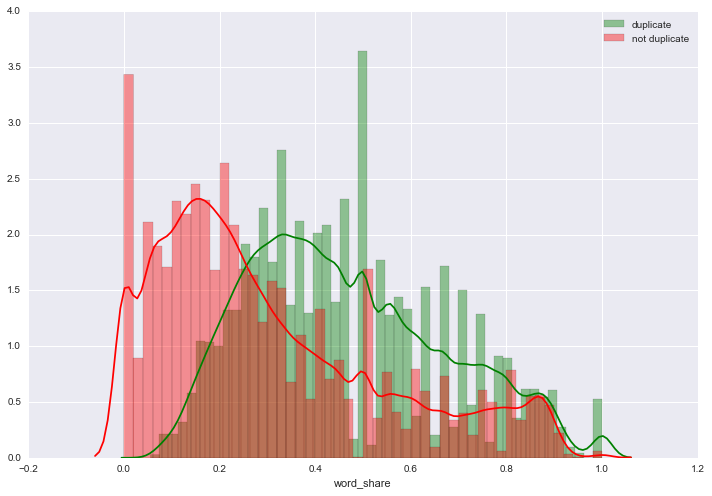

In [96]:
plt.figure(figsize=(12, 8))
sns.distplot(train.ix[train['is_duplicate'] == 1, 'word_share'], color = 'green', label="duplicate")
sns.distplot(train.ix[train['is_duplicate'] == 0, 'word_share'], color = 'red', label="not duplicate")
plt.legend()

<h2>Frequency of question asked</h2>

In [97]:
questions = train['question1_cleaned'].tolist()
foo = train['question2_cleaned'].tolist()
questions.extend(foo)
len(questions)

808576

In [98]:
questions = pd.Series(Counter(questions))
questions.head()

                                                                                                     14
   18002514919   comodo antivirus tech support number                                                 1
   linksys router tech support number 1 8002514919  linksys router support phone number               3
 18002514919  cisco routertech support phone number cisco router tech support number cisco router     1
 a woman who wants to kiss me in simplified chinese                                                   1
dtype: int64

In [99]:
train["q1freq"] = train['question1_cleaned'].map(questions)-1
train["q2freq"] = train['question2_cleaned'].map(questions)-1
train["freq"] = train["q1freq"] + df["q2freq"]
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,word_share,q1freq,q2freq,freq
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,what is the step by step guide to invest in share market in india,what is the step by step guide to invest in share market,0.916667,0,0,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,what is the story of kohinoor kohinoor diamond,what would happen if the indian government stole the kohinoor kohinoor diamond back,0.285714,3,1,4
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,how can i increase the speed of my internet connection while using a vpn,how can internet speed be increased by hacking through dns,0.200000,0,0,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divided by 2423,0.000000,0,0,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,which one dissolve in water quikly sugar salt methane and carbon di oxide,which fish would survive in salt water,0.250000,2,0,2


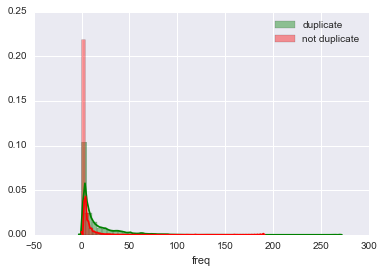

In [100]:
sns.distplot(train.ix[train['is_duplicate'] == 1, 'freq'], color = 'green', label="duplicate")
sns.distplot(train.ix[train['is_duplicate'] == 0, 'freq'], color = 'red', label="not duplicate")
plt.legend()

<h1>Validation</h1>

In [102]:
y = train["is_duplicate"]
df_train = train[["word_share", "freq"]]
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.3, random_state=0)

In [113]:
class_names = y.unique()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('double'),2) / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig("confusematrix.png")

*********************************************
Accuracy 0.7160619027595703
classification report 
             precision    recall  f1-score   support

          0       0.73      0.86      0.79     76633
          1       0.66      0.46      0.55     44654

avg / total       0.71      0.72      0.70    121287

Normalized confusion matrix
[[ 0.86381846  0.13618154]
 [ 0.53751064  0.46248936]]


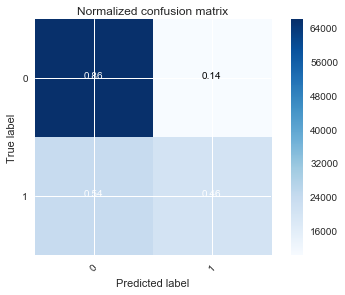

In [114]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred= lr.predict(X_test) 
print("*********************************************")
print("Accuracy {}".format(met.accuracy_score(y_test, y_pred)))
print("classification report \n{}".format(met.classification_report(y_test, y_pred)))
cnf_matrix = met.confusion_matrix(y_test,y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                              title='Normalized confusion matrix')
plt.show()

<h1>Predicting Test set and creating submission file</h1>

In [85]:
test.head()

,question1,question2
0,How does the Surface Pro himself 4 compare with iPad Pro?,Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?
1,Should I have a hair transplant at age 24? How much would it cost?,How much cost does hair transplant require?
2,What but is the best way to send money from China to the US?,What you send money to China?
3,Which food not emulsifiers?,What foods fibre?
4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [87]:
#test = test.dropna()
test = test.fillna("")
test['question1_cleaned'] = test['question1'].apply(clean_question, args=(translator,))
test['question2_cleaned'] = test['question2'].apply(clean_question, args=(translator,))

test['word_share'] = test.apply(normalized_word_share, axis=1)

In [89]:
df_train = train["word_share"].to_frame()
df_test = test["word_share"].to_frame()
y = train["is_duplicate"].tolist()

model = LogisticRegression()
model.fit(df_train,y)
y_pred = model.predict(df_test)
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [88]:
len(ids)

2345796

In [90]:
preds_fnl = pd.DataFrame()
preds_fnl["test_id"] = ids
preds_fnl["is_duplicate"] = y_pred
preds_fnl[["test_id","is_duplicate"]].to_csv("solution.csv", index=False)